# Demand Planning KPI Monitor

In [1]:
import os, sys, gc, datetime, time

import pandas as pd
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
from pandas.plotting import register_matplotlib_converters
from pandas import ExcelWriter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib. dates as mdates
%matplotlib inline

import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()

from pyspark.sql import SparkSession
from impala.dbapi import connect

In [2]:
date_str = datetime.datetime.now().strftime('%Y%m%d')

report_date = datetime.datetime.strptime(date_str, '%Y%m%d').date()

In [93]:
record_folder = '/data/jupyter/Carrefour-China-Supply-Chain-Forecast/output/monitoring/'

detention_rate_dc_file = f"report_detention_rate_dc_{date_str}.xlsx"

detention_rate_store_file = f"report_detention_rate_store_{date_str}.xlsx"

stock_level_dc_file = f"report_stock_level_dc_{date_str}.xlsx"

stock_level_store_file = f"report_stock_level_store_{date_str}.xlsx"

service_level_file = f"report_service_level_{date_str}.xlsx"

consistency_file = f'report_consistency_items_{date_str}.xlsx'

oos_file = f'report_oos_item_list_{date_str}.xlsx'

In [4]:
print('Report generation time:', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), end='\n\n')

Report generation time: 2019-09-10 10:01:55



---

In [5]:
## Get parameters, if not given then fall back to default values

if 'ATF_Q_KPI_MONITOR_PARAMETERS' in os.environ:
    print('Using external parameters.')
    _param = os.environ['ATF_Q_KPI_MONITOR_PARAMETERS']
    (DETENTION_START, DETENTION_END, SERVICE_LEVEL_START, SERVICE_LEVEL_END,
     STOCK_LEVEL_START, STOCK_LEVEL_END, CONSISTENCY_START, CONSISTENCY_END) = [
        i.strip() for i in _param.split(',')]
else:
    print('Using default parameters.')
    tfmt = '%Y%m%d'
    _end = datetime.datetime.now().strftime(tfmt)
    _start = (datetime.datetime.now() - datetime.timedelta(days=60)).strftime(tfmt)
    DETENTION_START, DETENTION_END = _start, _end
    SERVICE_LEVEL_START, SERVICE_LEVEL_END = _start, _end
    STOCK_LEVEL_START, STOCK_LEVEL_END = _start, _end
    CONSISTENCY_START, CONSISTENCY_END = _start, _end
    OOS_CHECK_DATE = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime(tfmt)

print('Detention:', DETENTION_START, DETENTION_END, sep='\t')
print('Stock level:', STOCK_LEVEL_START, STOCK_LEVEL_END, sep='\t')
print('Consistency:', CONSISTENCY_START, CONSISTENCY_END, sep='\t')
print('Service level:', SERVICE_LEVEL_START, SERVICE_LEVEL_END, sep='\t')
print('OOS_CHECK_DATE:', OOS_CHECK_DATE, sep='\t')

Using default parameters.
Detention:	20190712	20190910
Stock level:	20190712	20190910
Consistency:	20190712	20190910
Service level:	20190712	20190910
OOS_CHECK_DATE:	20190909


In [6]:
T0 = time.time()

In [7]:
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars /data/jupyter/kudu-spark2_2.11-1.8.0.jar pyspark-shell'
warehouse_location = os.path.abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("Forecast monitoring process") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.blacklist.enabled", False) \
    .config("spark.driver.memory", '6g') \
    .config("spark.executor.memory", '6g') \
    .config("spark.num.executors", '14') \
    .enableHiveSupport() \
    .getOrCreate()

In [8]:
kudu_tables = [
    'lfms.daily_dctrxn', 'lfms.daily_dcstock', 'lfms.ord', 'lfms.daily_shipment'
]

for tbl in kudu_tables:
    spark.read.format('org.apache.kudu.spark.kudu') \
    .option('kudu.master', "dtla1apps11:7051,dtla1apps12:7051,dtla1apps13:7051") \
    .option('kudu.table', f'impala::{tbl}') \
    .load() \
    .registerTempTable('{}'.format(tbl.replace('.', '_')))

In [9]:
def get_query(sql_path, kudu_replace=None, **query_params):
    with open(sql_path, 'r') as f:
        query = f.read()
    if kudu_replace is not None:
        for k, v in kudu_replace.items():
            query = query.replace(k, v)
   
    query = query.format(**query_params)

    return query

In [10]:
def read_query_and_fetch(sql_path, create_table=False, get_query=False, kudu_replace=None, **query_params):
    with open(sql_path, 'r') as f:
        query = f.read()
    if kudu_replace is not None:
        for k, v in kudu_replace.items():
            query = query.replace(k, v)
    if not create_table:
        ## remove lines with `table`
        q0 = query
        query = '\n'.join([line for line in q0.split('\n')
                           if ('drop table' not in line.lower())
                           and ('create table' not in line.lower())])
    query = query.format(**query_params)
    if get_query:
        return query
    return spark.sql(query).toPandas()

In [11]:
def run_sql_with_impala(sql):
    with connect(host='dtla1apps14', port=21050, auth_mechanism='PLAIN', user='CHEXT10211', password='datalake2019',
                 database='vartefact') as conn:
        curr = conn.cursor()
        curr.execute(sql)

In [12]:
dc_stock_sql = get_query(
    'sql/record_dc_stock.sql',
    database_name='vartefact', date_start=DETENTION_START, date_end=DETENTION_END
)

In [13]:
run_sql_with_impala(dc_stock_sql.replace("\n", " "))

In [14]:
store_stock_sql = get_query(
    'sql/record_store_stock.sql',
    database_name='vartefact', date_start=DETENTION_START, date_end=DETENTION_END
)

In [15]:
run_sql_with_impala(store_stock_sql.replace("\n", " "))

---

# 1. Detention rate

### 1.1 Detention rate - DC

In [17]:
detention_dc = spark.sql(get_query(
    'sql/kpi_detention_rate_dc.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [18]:
detention_dc_supplier = spark.sql(get_query(
    'sql/kpi_detention_rate_dc_supplier.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [65]:
detention_dc_writer = ExcelWriter(record_folder + detention_rate_dc_file)

In [135]:
def plot_detention_dc(df, title):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')
    fig, ax = plt.subplots(figsize=(12, 3))
    flow_A = df1[df1.rotation == 'A']
    flow_B = df1[df1.rotation == 'B']
    ax.plot(flow_A.date_dt, flow_A.detention_rate, label='Flow A')
    ax.plot(flow_B.date_dt, flow_B.detention_rate, label='Flow B')
    ax.legend()
    ax.set_title(f'DC detention rate for {title}')
    fig.autofmt_xdate()
    
    print(f'Latest detention rate for {title}:')
    display(df[['date_key', 'rotation', 'detention_rate']].tail(9).style.hide_index())
    
    df1.to_excel(detention_dc_writer, sheet_name=title, index=False)

Latest detention rate for all items:


date_key,rotation,detention_rate
20190908,A,0.836538
20190908,B,0.82716
20190909,A,0.826923
20190909,B,0.833333
20190910,A,0.855769
20190910,B,0.864198


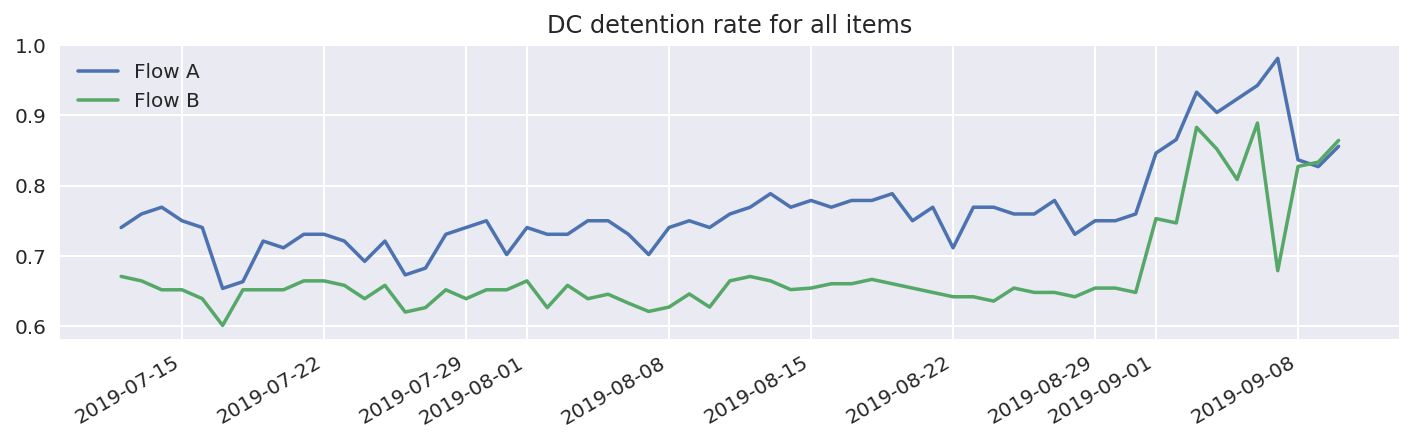

In [136]:
plot_detention_dc(detention_dc, 'all items')

Latest detention rate for Nestle:


date_key,rotation,detention_rate
20190908,A,0.909091
20190908,B,0.794118
20190909,A,1
20190909,B,0.529412
20190910,A,1
20190910,B,0.794118


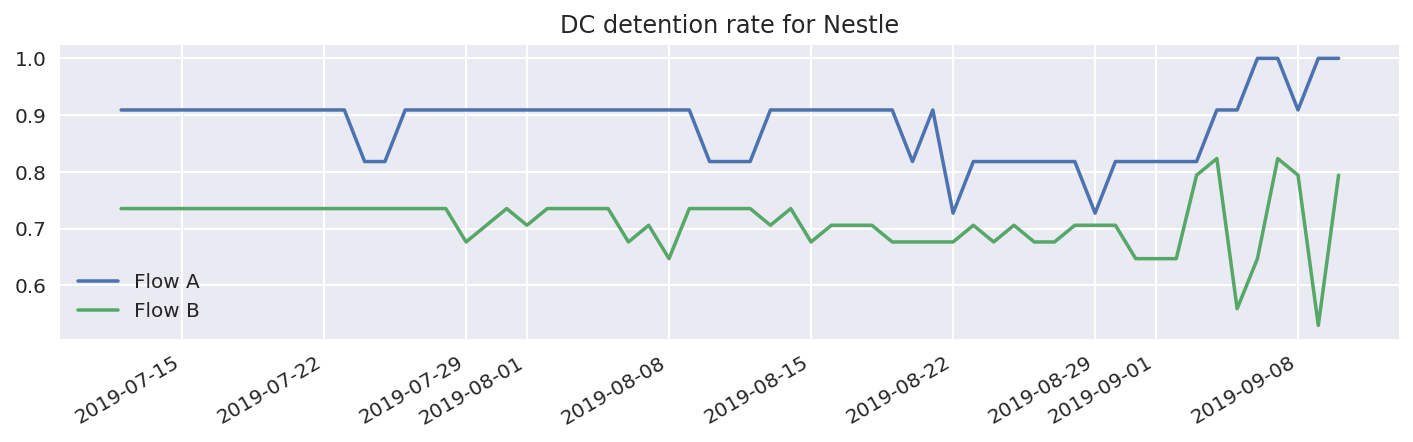

In [137]:
plot_detention_dc(detention_dc_supplier[detention_dc_supplier['holding_code'] == '002'], 'Nestle')

Latest detention rate for P&G:


date_key,rotation,detention_rate
20190908,A,0.745455
20190908,B,0.833333
20190909,A,0.727273
20190909,B,0.911111
20190910,A,0.781818
20190910,B,0.877778


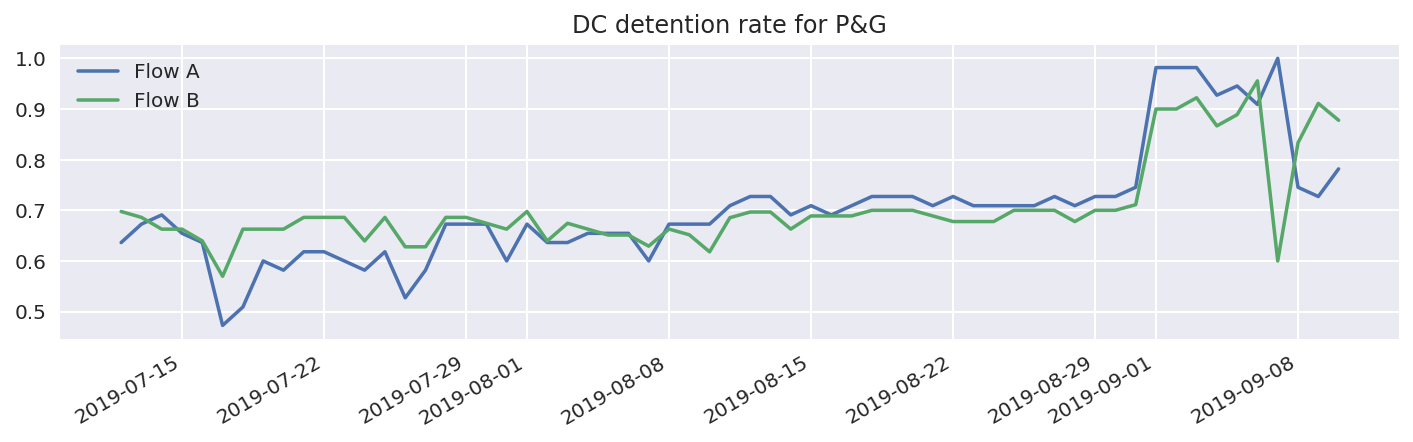

In [138]:
plot_detention_dc(detention_dc_supplier[detention_dc_supplier['holding_code'] == '693'], 'P&G')

Latest detention rate for Unilever:


date_key,rotation,detention_rate
20190908,A,0.947368
20190908,B,0.842105
20190909,A,0.921053
20190909,B,0.921053
20190910,A,0.921053
20190910,B,0.894737


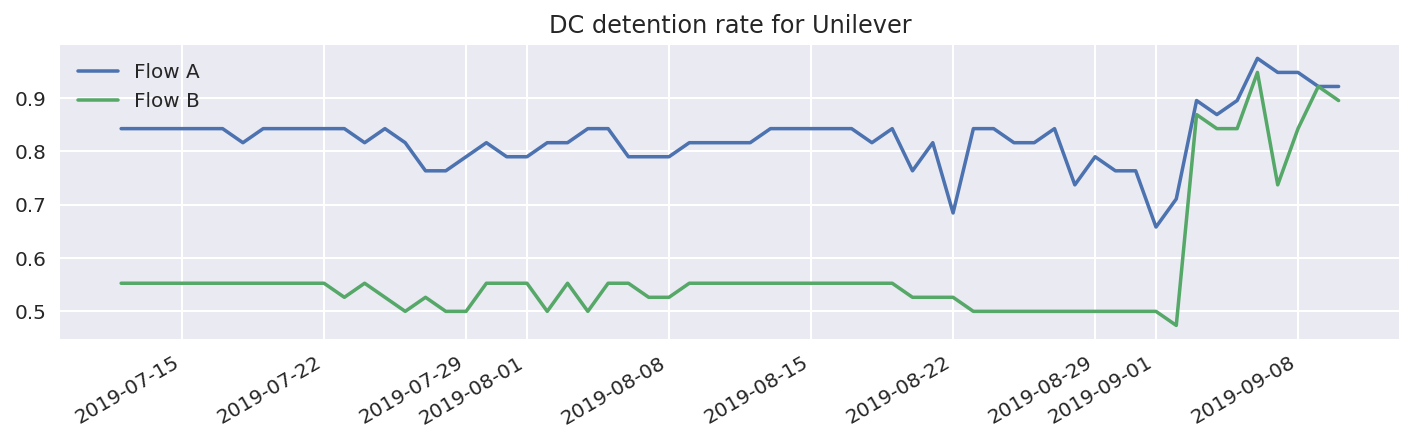

In [139]:
plot_detention_dc(detention_dc_supplier[detention_dc_supplier['holding_code'] == '700'], 'Unilever')

In [71]:
detention_dc_writer.save()
print(f'Please check file {detention_rate_dc_file} for detail')

---

### 1.2 Detention rate - Store

In [26]:
detention_all_store = spark.sql(get_query(
    'sql/kpi_detention_rate_all_store.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [27]:
detention_store = spark.sql(get_query(
    'sql/kpi_detention_rate_store.sql',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [72]:
detention_store_writer = ExcelWriter(record_folder + detention_rate_store_file)

In [133]:
def plot_detention_all_store(df):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')
    fig, ax = plt.subplots(figsize=(12, 3))
    flow_A = df1[df1.rotation == 'A']
    flow_B = df1[df1.rotation == 'B']
    flow_X = df1[df1.rotation == 'X']
    ax.plot(flow_A.date_dt, flow_A.detention_rate, label='Flow A')
    ax.plot(flow_B.date_dt, flow_B.detention_rate, label='Flow B')
    ax.plot(flow_X.date_dt, flow_X.detention_rate, label='Flow X')
    ax.legend()
    ax.set_title(f'Store detention rate by day')
    fig.autofmt_xdate()
    print(f'Latest detention rate:')

    display(df[['date_key', 'rotation', 'detention_rate']].tail(9).style.hide_index())
    
    flow_A.to_excel(detention_store_writer, sheet_name="Flow A", index=False)
    flow_B.to_excel(detention_store_writer, sheet_name="Flow B", index=False)
    flow_X.to_excel(detention_store_writer, sheet_name="Flow X", index=False)

In [74]:
def plot_detention_store(df):
    df1 = df.sort_values(by=['rotation', 'date_key', 'store_code']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')

    dr = df1.groupby(['store_code', 'rotation'])['detention_rate'].mean().reset_index()
    a = dr.loc[dr.rotation == 'A', 'detention_rate'].sort_values().values
    b = dr.loc[dr.rotation == 'B', 'detention_rate'].sort_values().values
    x = dr.loc[dr.rotation == 'X', 'detention_rate'].sort_values().values
    
    fig, axes = plt.subplots(figsize=(16, 4), ncols=3)

    axes[0].plot(a, 'o', ms=6)
    axes[1].plot(b, 'o', ms=6)
    axes[2].plot(x, 'o', ms=6)
    
    axes[0].set_title('Store detention rate by store: Flow A')
    axes[1].set_title('Store detention rate by store: Flow B')
    axes[2].set_title('Store detention rate by store: Flow X')
    
    axes[0].set_ylim(min(0.75, a.min()), 1)
    axes[1].set_ylim(min(0.75, b.min()), 1)
    axes[2].set_ylim(min(0.75, x.min()), 1)
    
    fig.tight_layout()
    
    df1[df1.rotation == 'A'].to_excel(detention_store_writer, sheet_name="By store flow A", index=False)
    df1[df1.rotation == 'B'].to_excel(detention_store_writer, sheet_name="By store flow B", index=False)
    df1[df1.rotation == 'X'].to_excel(detention_store_writer, sheet_name="By store flow X", index=False)

Latest detention rate:


date_key,rotation,detention_rate
20190907,A,0.976222
20190907,B,0.971458
20190907,X,0.966151
20190908,A,0.972513
20190908,B,0.976091
20190908,X,0.966151
20190909,A,0.96815
20190909,B,0.975941
20190909,X,0.963882


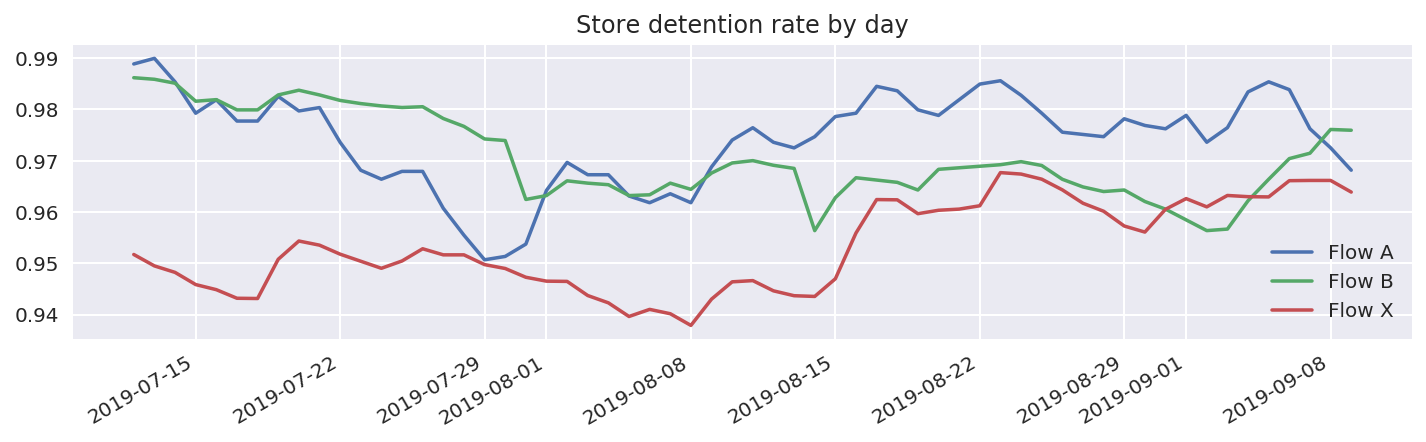

In [134]:
plot_detention_all_store(detention_all_store)

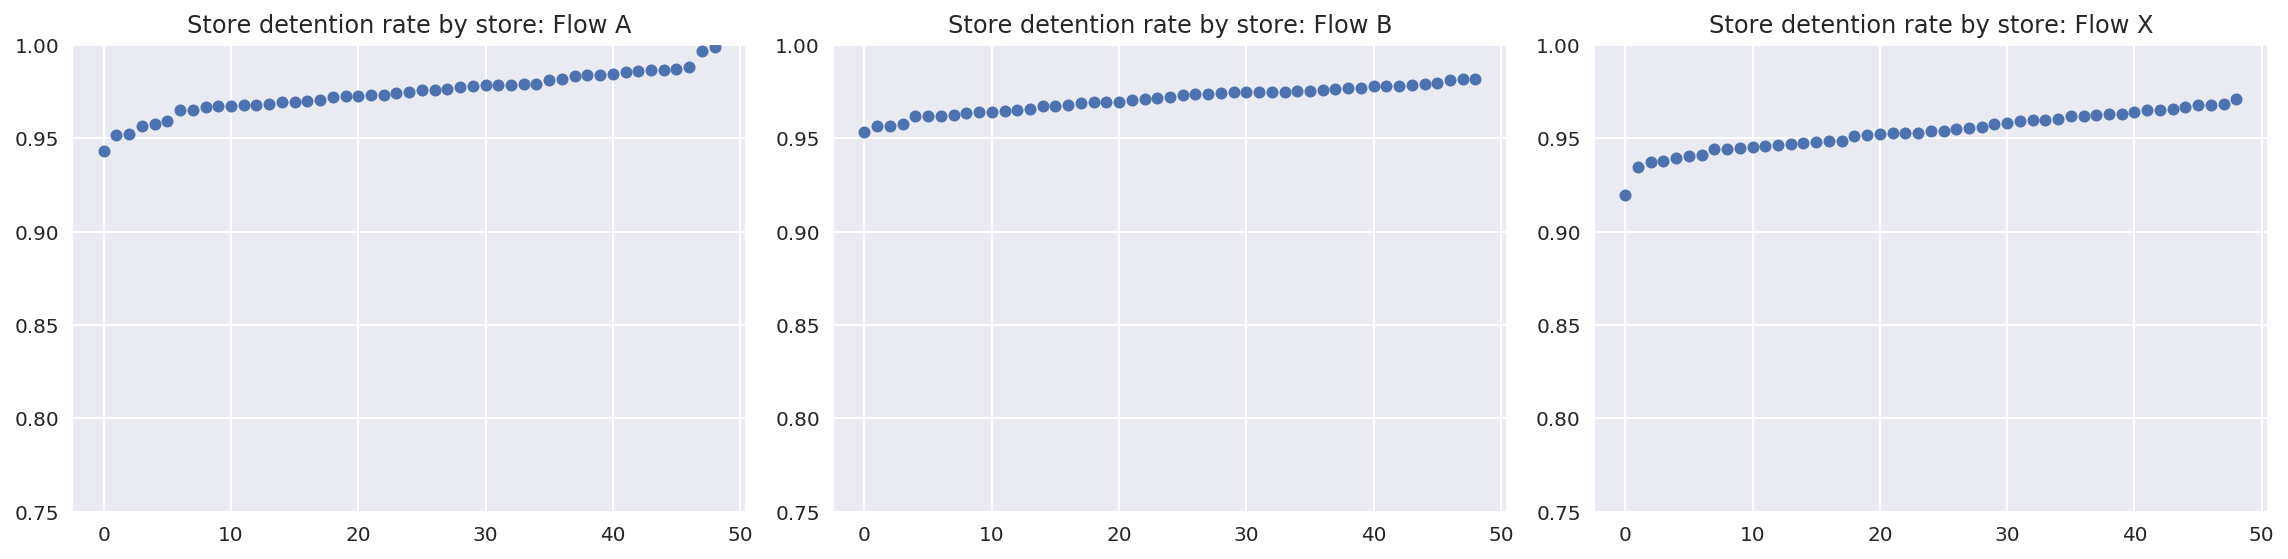

In [76]:
plot_detention_store(detention_store) 

In [77]:
detention_store_writer.save()
print(f'Please check file {detention_rate_store_file} for detail')

---

## 2 Stock level

### 2.1 Stock level - DC

In [34]:
stock_level_dc = spark.sql(get_query(
    'sql/kpi_stock_level_dc.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [78]:
stock_dc_writer = ExcelWriter(record_folder + stock_level_dc_file)

In [79]:
def plot_stock_level_dc(df, title):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    sl = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_level'].sum().reset_index()
    sl['date_key'] = pd.to_datetime(sl.date_key, format='%Y%m%d')
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    for i, rotation in enumerate(['A', 'B']):
        axes[i].set_title(f'DC stock level {title} Rotation {rotation}')
        for dm in sl.in_dm.unique():
            d = sl[(sl.in_dm == dm) & (sl.rotation == rotation)]
            axes[i].plot(d.date_key, d.stock_level, label="DM" if dm else "Non-DM")
            axes[i].legend()
    fig.autofmt_xdate(); fig.tight_layout()
    
    df1.to_excel(stock_dc_writer, sheet_name=title, index=False)

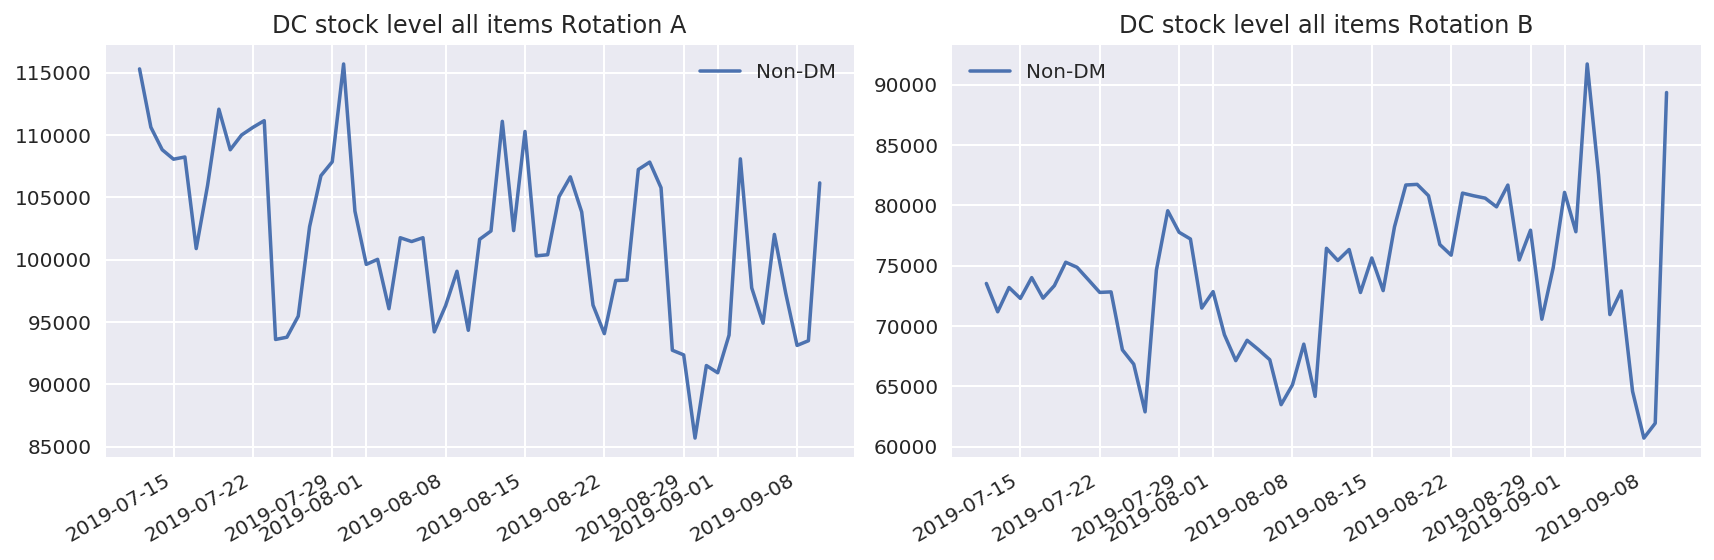

In [80]:
plot_stock_level_dc(stock_level_dc, 'all items')

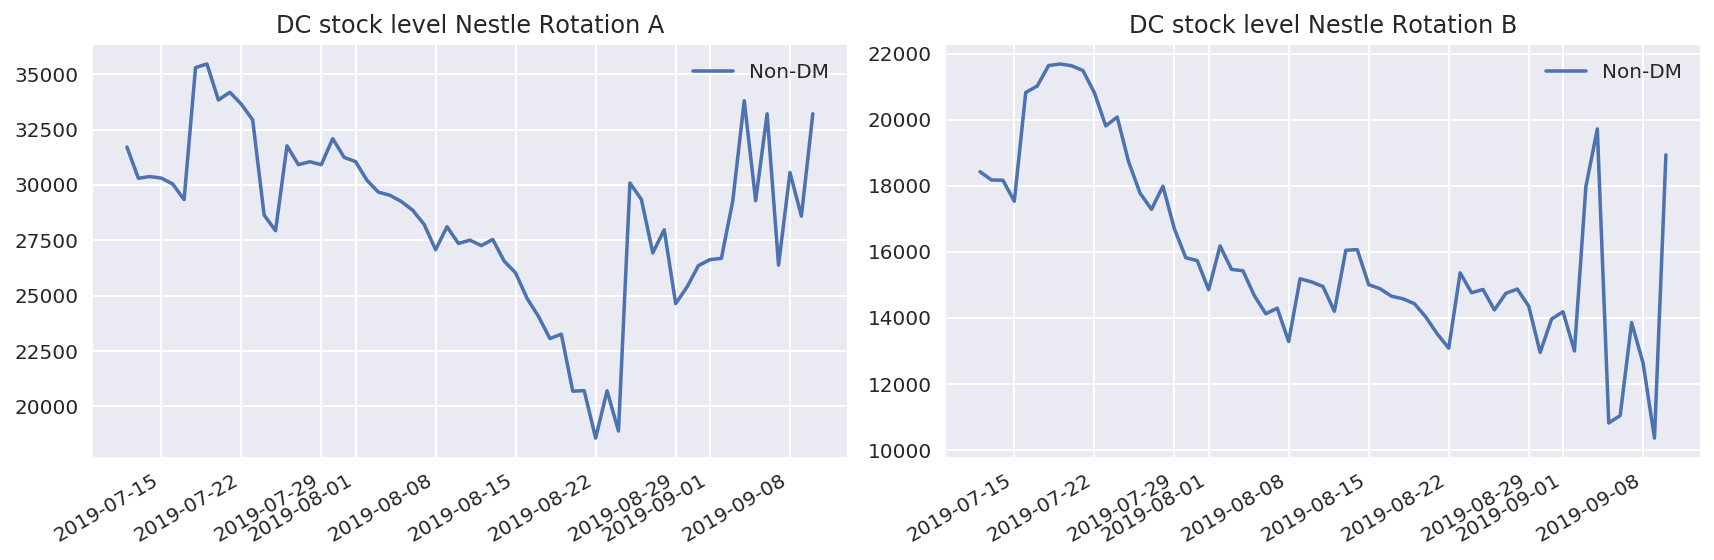

In [81]:
plot_stock_level_dc(stock_level_dc[stock_level_dc['holding_code'] == '002'], 'Nestle')

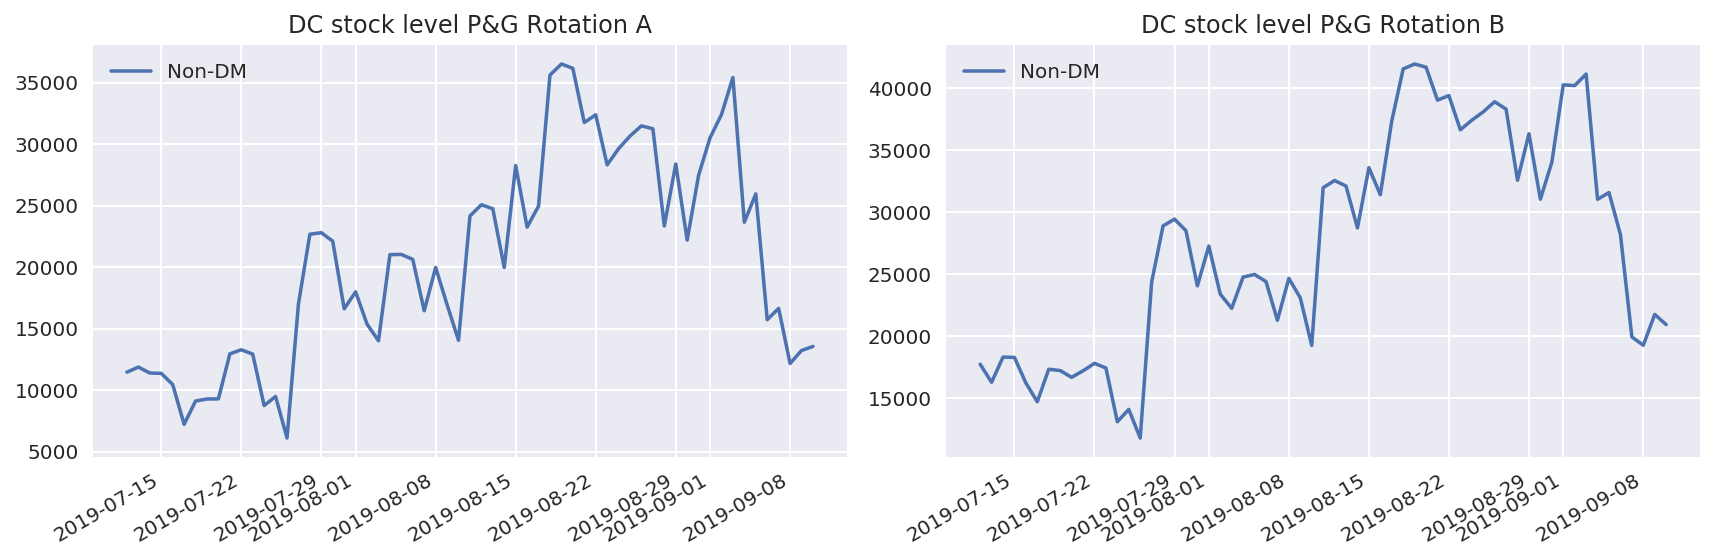

In [82]:
plot_stock_level_dc(stock_level_dc[stock_level_dc['holding_code'] == '693'], 'P&G')

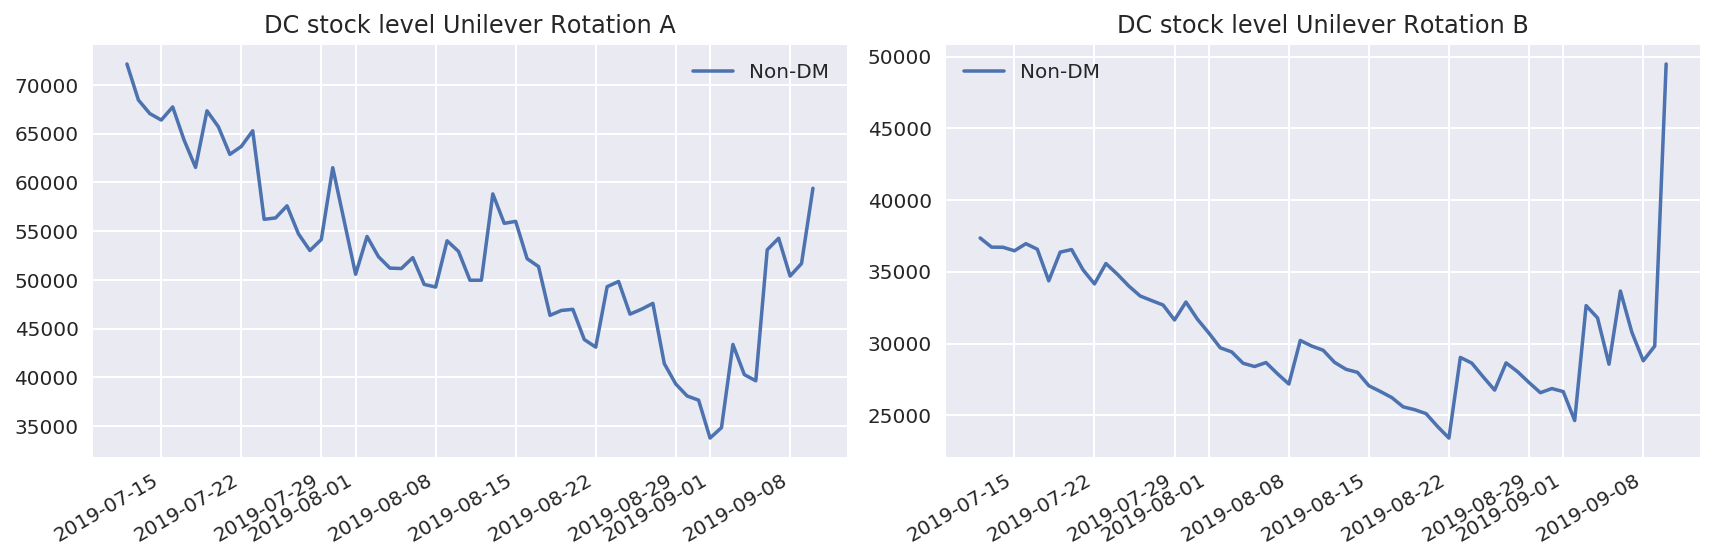

In [83]:
plot_stock_level_dc(stock_level_dc[stock_level_dc['holding_code'] == '700'], 'Unilever')

In [84]:
stock_dc_writer.save()
print(f'Please check file {stock_level_dc_file} for detail')

---

### 2.2  Stock level - store

In [42]:
stock_level_store = spark.sql(get_query(
    'sql/kpi_stock_level_store.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database_name='vartefact', run_date=STOCK_LEVEL_END
)).toPandas()

In [85]:
stock_store_writer = ExcelWriter(record_folder + stock_level_store_file)

In [86]:
def plot_stock_level_store(df, title):
    df1 = df.sort_values(by=['store_code', 'rotation', 'date_key']).copy()
    sl_all_stores = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_level'].sum().reset_index()
    sl_all_stores['date_key'] = pd.to_datetime(sl_all_stores.date_key, format='%Y%m%d')
    fig, axes = plt.subplots(figsize=(14, 3.5), ncols=3)
    for i, rotation in enumerate(sl_all_stores.rotation.unique()):
        axes[i].set_title(f'Store stock for {title} Rotation {rotation}')
        for dm in sl_all_stores.in_dm.unique():
            d = sl_all_stores[(sl_all_stores.in_dm == dm) & (sl_all_stores.rotation == rotation)]
            axes[i].plot(d.date_key, d.stock_level, label="DM" if dm else "Non-DM")
            axes[i].legend()
    fig.autofmt_xdate(); fig.tight_layout()
    
    df1.to_excel(stock_store_writer, sheet_name=title, index=False)

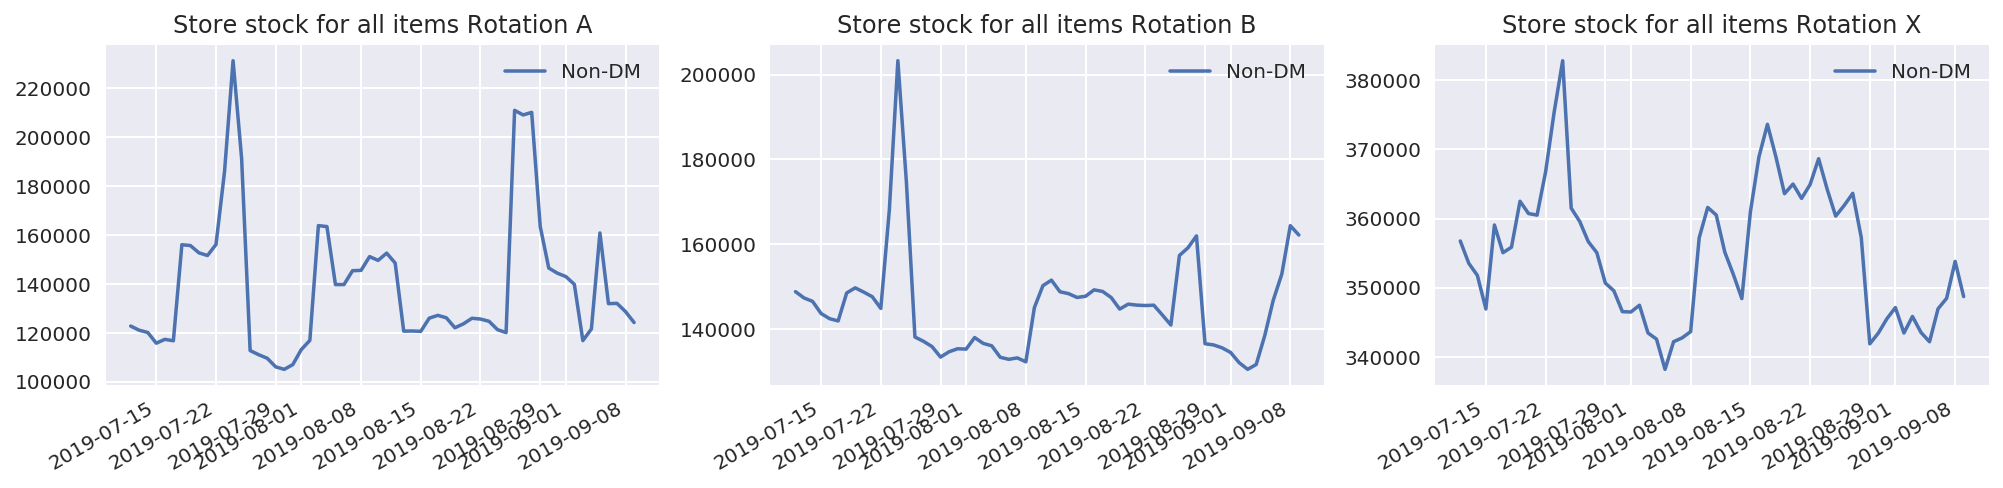

In [87]:
plot_stock_level_store(stock_level_store, "all items")

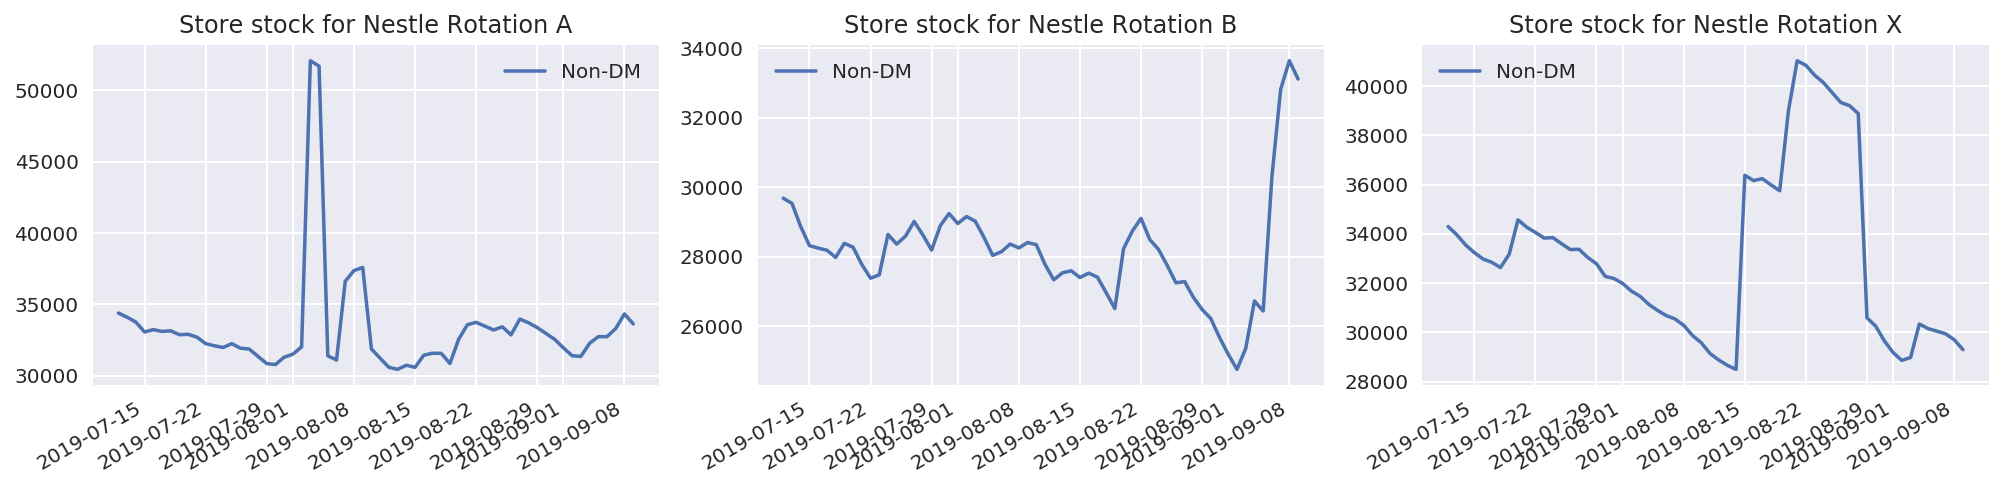

In [88]:
plot_stock_level_store(stock_level_store[stock_level_store['con_holding'] == '002'], 'Nestle')

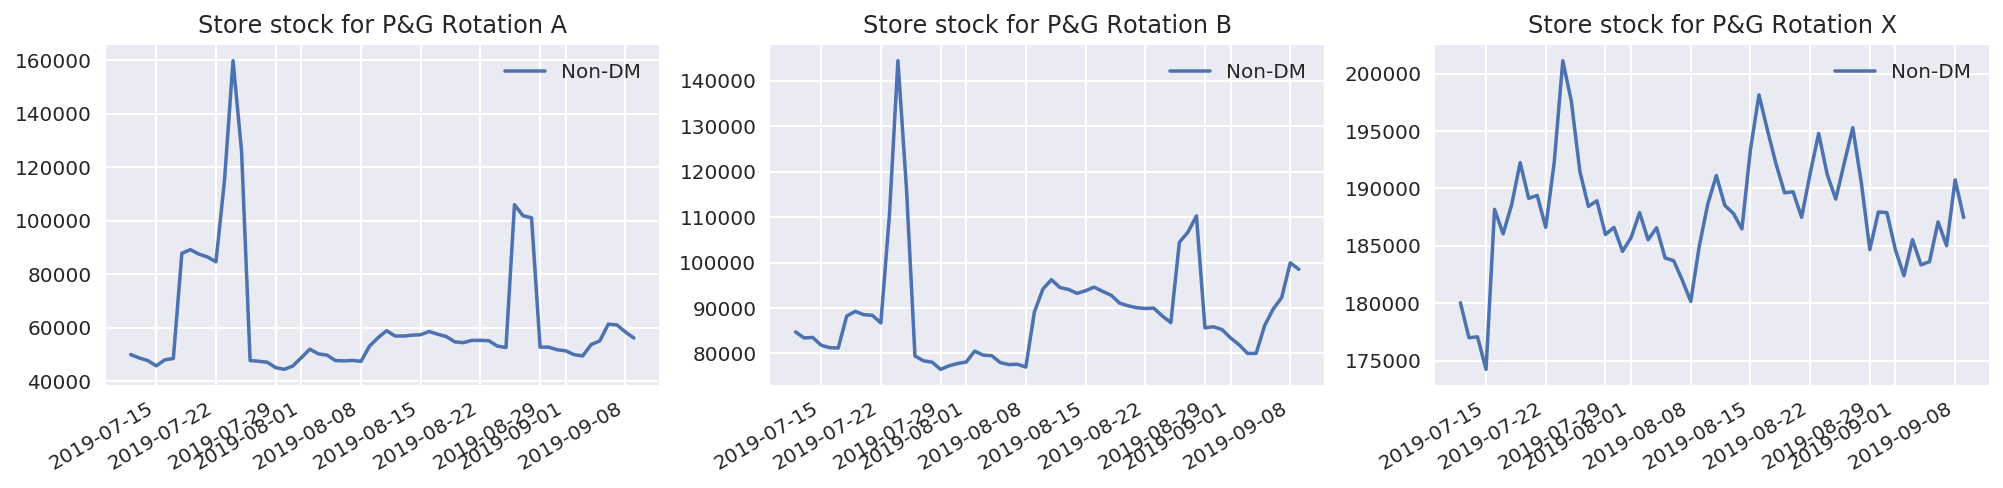

In [89]:
plot_stock_level_store(stock_level_store[stock_level_store['con_holding'] == '693'], 'P&G')

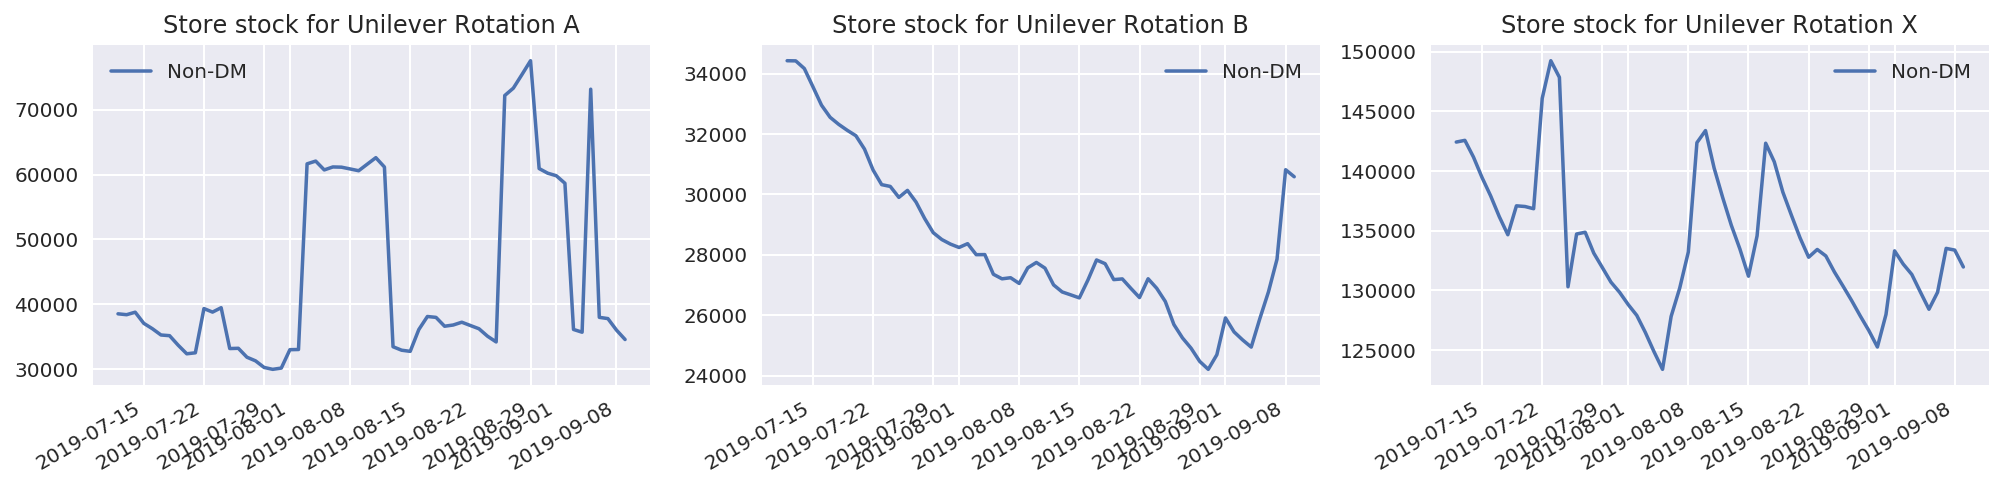

In [90]:
plot_stock_level_store(stock_level_store[stock_level_store['con_holding'] == '700'], 'Unilever')

In [91]:
stock_store_writer.save()
print(f'Please check file {stock_level_store_file} for detail')

---

## 3  Consistency

In [49]:
def to_dt(x):
    return pd.to_datetime(x, format='%Y%m%d')

def process_for_consistency(sim_hist):
    ord0 = sim_hist[sim_hist.order_day == sim_hist.run_date]
    if ord0.shape[0] == 0:
        return pd.DataFrame()

    chk = ord0[['sub_id', 'item_id', 'item_code', 'item_name', 'barcode', 'rotation',
                'supplier_name', 'order_day', 'order_qty_box']] \
        .rename(columns={'order_qty_box': 'order_qty (box)'}).copy()
    for i in range(2, 8):  # week 2~7
        ord1 = sim_hist[(to_dt(sim_hist.order_day) - to_dt(sim_hist.run_date)).dt.days == int(i * 7)]
        chk = chk.merge(ord1[['sub_id', 'order_day', 'order_qty_box']]
                        .rename(columns={'order_qty_box': f'Week-{i}_before_order_qty'}),
                        on=['sub_id', 'order_day'], how='left')

    ## aggregate by order week
    chk['order_day'] = to_dt(chk.order_day)
    chk['order_week'] = (chk.order_day - pd.to_timedelta(chk.order_day.dt.weekday, unit='days')
                        ).dt.strftime('%Y%m%d')
    chk['Week of year'] = 'W' + chk['order_day'].dt.week.astype(str)
    chk = chk.drop(columns=['order_day', 'sub_id'])
    chk = chk.groupby(['item_id', 'item_code', 'item_name', 'barcode', 'rotation',
                       'supplier_name', 'order_week', 'Week of year']).agg(lambda x: x.sum(skipna=False)).reset_index()

    for i in range(2, 8):  # calculate consistency error
        chk[f'Week-{i}_before_error'] = (
            chk[f'Week-{i}_before_order_qty'] -
            chk['order_qty (box)']) / (chk['order_qty (box)'] + 1.e-6)
        chk[f'Week-{i}_before_run_date'] = (to_dt(chk.order_week) -
                                            datetime.timedelta(days=i*7)).dt.strftime('%m/%d/%Y')

    columns = ['item_id', 'item_code', 'item_name', 'barcode', 'rotation',
               'supplier_name', 'order_week', 'order_qty (box)', 'Week of year']
    for i in range(2, 8):
        columns += [f'Week-{i}_before_run_date', f'Week-{i}_before_order_qty', f'Week-{i}_before_error']
    return chk[columns]

def xavier_method_v2(forecast, actual):
    ''' sum(diff) / sum(forecast) '''
    return (actual - forecast).abs().sum() / (actual.sum() + 1.e-6)

In [50]:
## Only trigger on Sunday
if datetime.datetime.now().weekday() == 6:
    order_hist = spark.sql(get_query(
    'sql/kpi_consistency_order_hist.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database_name='vartefact', CONSISTENCY_START=CONSISTENCY_START, CONSISTENCY_END=CONSISTENCY_END,
    # kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)).toPandas()
    
    _onstock = order_hist[order_hist.rotation.isin(['A', 'B'])].copy()
    _onstock['order_qty_box'] = np.ceil(_onstock['order_qty'].astype('f8') / _onstock['pcb'].astype('f8'))
    chk_onstock = process_for_consistency(_onstock)

    _xdock = order_hist[order_hist.rotation == 'X'].copy()
    _xdock['order_qty_box'] = np.ceil(_xdock['order_qty'].astype('f8') / _xdock['pcb'].astype('f8'))
    _xdocking = (_xdock.groupby(['order_day', 'run_date', 'sub_id', 'rotation', 'item_id', 'item_code',
                                 'supplier_name', 'barcode', 'item_name'])['order_qty_box'].sum().reset_index())
    chk_xdocking = process_for_consistency(_xdocking)

    if chk_xdocking.shape[0] > 0 and chk_onstock.shape[0] > 0:
        ## Merge, keep only latest week, save to excel
        chk = pd.concat([chk_onstock, chk_xdocking], axis=0)
        chk = chk[chk.order_week == chk.order_week.max()]
        chk.sort_values(by='item_code') \
           .to_excel(record_folder + consistency_file,
                     sheet_name='template', index=False)
        ## Print overall consistency (only print week 2)
        flow_a = chk.query('rotation == "A"')
        flow_b = chk.query('rotation == "B"')
        flow_x = chk.query('rotation == "X"')
        print('Consistency (week 2):\nOverall: {:.2f}\nFlow A: {:.2f}%\nFlow B: {:.2f}%\nFlow X: {:.2f}%'
              .format(
                  xavier_method_v2(chk['Week-2_before_order_qty'], chk['order_qty (box)']),
                  xavier_method_v2(flow_a['Week-2_before_order_qty'], flow_a['order_qty (box)']),
                  xavier_method_v2(flow_b['Week-2_before_order_qty'], flow_b['order_qty (box)']),
                  xavier_method_v2(flow_x['Week-2_before_order_qty'], flow_x['order_qty (box)'])
              ))
    else:
        print(f'There is not enough order history data between {CONSISTENCY_START} and '
              f'{CONSISTENCY_END} to calculate consistency.')
else:
    print('Today is not Sunday. Will not calculate consistency.')

Today is not Sunday. Will not calculate consistency.


---

## 4 Service level

### 4.1 Service level - DC

In [94]:
sl_writer = ExcelWriter(record_folder + service_level_file)

In [51]:
sl_dc = read_query_and_fetch(
    'sql/kpi_service_level.sql',
    database_name='vartefact', date_start=SERVICE_LEVEL_START, date_end=SERVICE_LEVEL_END,
    kudu_replace={'lfms.daily_dctrxn': 'lfms_daily_dctrxn', 'lfms.ord': 'lfms_ord'}
)

In [52]:
def show_service_level_dc(df):
    df1 = df.copy()
    for col in ['trxn_qty_sum', 'basic_order_qty_sum', 'service_level']:
        df1[col] = df1[col].astype('f8')

    df1 = df1.rename(columns={'trxn_qty_sum': 'received_qty_sum', 
                              'basic_order_qty_sum': 'ordered_qty_sum'})
    
    df1.to_excel(sl_writer, sheet_name='DC service level', index=False)
    return df1.groupby('holding_code')[['service_level']].mean().reset_index().style.hide_index()

In [53]:
print('DC service level:')
show_service_level_dc(sl_dc)

DC service level:


holding_code,service_level
002,0.999969
693,0.999966
700,0.999978


### 4.1 Service level - Store

In [54]:
sl_store = read_query_and_fetch(
    'sql/kpi_service_level_store.sql',
    database_name='vartefact', date_start=SERVICE_LEVEL_START, date_end=SERVICE_LEVEL_END,
   kudu_replace={'lfms.daily_shipment':'lfms_daily_shipment'}
)

In [55]:
def show_service_level_store(df):
    df1 = df.copy()
    for col in ['order_qty_in_sku_sum', 'delivery_qty_in_sku_sum', 'service_level']:
        df1[col] = df1[col].astype('f8')

    df1 = df1.rename(columns={'delivery_qty_in_sku_sum': 'store_received_qty_sum', 
                              'order_qty_in_sku_sum': 'store_ordered_qty_sum'})
    
    df1.to_excel(sl_writer, sheet_name='Store service level', index=False)
    return df1.groupby('holding_code')[['service_level']].mean().reset_index().style.hide_index()


In [56]:
print('store service level:')
show_service_level_store(sl_store)

store service level:


holding_code,service_level
002,0.602315
693,0.692345
700,0.766446


In [ ]:
sl_writer.save()

## 5 Out-of-Stock item list

In [125]:
oos_writer = ExcelWriter(record_folder + oos_file)

In [126]:
oos_item_list_dc = read_query_and_fetch(
    'sql/kpi_oos_item_list_dc.sql',
    # database_name='vartefact', date_start='20190701', date_end='20190730',
    database_name='vartefact', oos_check_date=OOS_CHECK_DATE,
    kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [127]:
print(f'{len(oos_item_list_dc)} out of stock DC items found')
oos_item_list_dc.to_excel(oos_writer, sheet_name='Out of stock items in DC', index=False)

45 out of stock DC items found


In [128]:
oos_item_list_store = read_query_and_fetch(
    'sql/kpi_oos_item_list_store.sql',
    # database_name='vartefact', date_start='20190701', date_end='20190730',
    database_name='vartefact', oos_check_date=OOS_CHECK_DATE,
    # kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [129]:
print(f'{len(oos_item_list_store)} out of stock store items found')
oos_item_list_store.to_excel(oos_writer, sheet_name='Out of stock items in store', index=False)

1071 out of stock store items found


In [130]:
oos_writer.save()
print(f'Please check file {oos_file} for detail')

Please check file report_oos_item_list_20190910.xlsx for detail


In [62]:
T1 = time.time()

---

In [63]:
print(f'Generating monitoring report takes {T1-T0:.2f} seconds.')

Generating monitoring report takes 520.62 seconds.
